In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict copper ("Close") returns with *lagged* copper returns. 

In [2]:
# Futures contract on the copper price:

copper = pd.read_csv(
    Path("copper.csv"), index_col="Date",parse_dates=True
)
copper.head()

Close Volume    Open    High     Low
Date                                             
2014-12-15  2.8785  40167  2.9245  2.9470  2.8635
2014-12-16  2.8585  49107  2.8725  2.8860  2.8440
2014-12-17  2.8705  43116  2.8670  2.8925  2.8270
2014-12-18  2.8535  35177  2.8695  2.8855  2.8425
2014-12-19  2.8845  30839  2.8460  2.9035  2.8460

In [3]:
# Trim the dataset to begin on December 15, 2014
copper = copper.loc["2014-12-15":, :]
copper.head()



Close Volume    Open    High     Low
Date                                             
2014-12-15  2.8785  40167  2.9245  2.9470  2.8635
2014-12-16  2.8585  49107  2.8725  2.8860  2.8440
2014-12-17  2.8705  43116  2.8670  2.8925  2.8270
2014-12-18  2.8535  35177  2.8695  2.8855  2.8425
2014-12-19  2.8845  30839  2.8460  2.9035  2.8460

# Data Preparation

### Returns

In [4]:
# Create a series using "Close" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
copper['Return'] = copper.Close.pct_change() * 100
copper = copper.replace(-np.inf, np.nan).dropna()
copper.tail()

Close Volume    Open    High     Low    Return
Date                                                       
2019-12-09  2.7585  93331  2.7455  2.7620  2.7200  1.752121
2019-12-10  2.7555    395  2.7500  2.7570  2.7460 -0.108755
2019-12-11  2.7895  76152  2.7935  2.7940  2.7905  1.233896
2019-12-12  2.7965  99303  2.8045  2.8145  2.8030  0.250941
2019-12-13  2.7805    476  2.8150  2.8200  2.7620 -0.572144

### Lagged Returns 

In [5]:
# Create a lagged return using the shift function
copper['Lagged_Return'] = copper.Return.shift()
copper = copper.replace(-np.inf, np.nan).dropna()
copper.tail()

Close Volume    Open    High     Low    Return  Lagged_Return
Date                                                                      
2019-12-09  2.7585  93331  2.7455  2.7620  2.7200  1.752121       1.802478
2019-12-10  2.7555    395  2.7500  2.7570  2.7460 -0.108755       1.752121
2019-12-11  2.7895  76152  2.7935  2.7940  2.7905  1.233896      -0.108755
2019-12-12  2.7965  99303  2.8045  2.8145  2.8030  0.250941       1.233896
2019-12-13  2.7805    476  2.8150  2.8200  2.7620 -0.572144       0.250941

### Train Test Split

In [6]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = copper[:'2018']
test = copper['2018':]


In [7]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [8]:
X_train.head()

Lagged_Return
Date                     
2014-12-17      -0.694806
2014-12-18       0.419801
2014-12-19      -0.592231
2014-12-22       1.086385
2014-12-23      -0.416017

# Linear Regression Model

In [9]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [10]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [11]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions
#Results.head()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A754CE4198>,
      dtype=object)

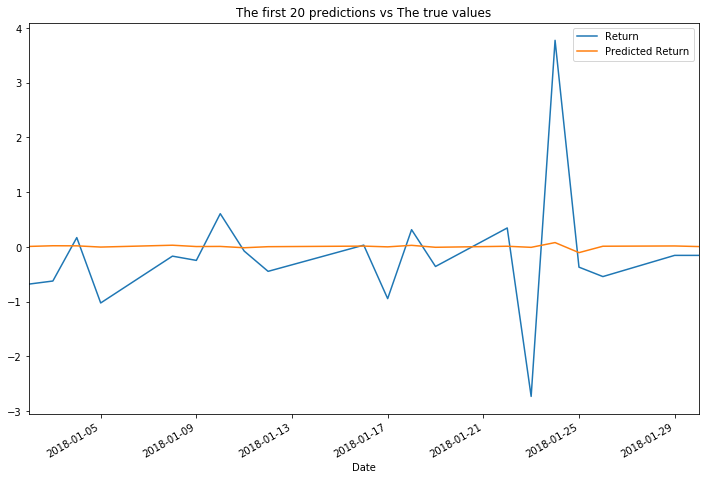

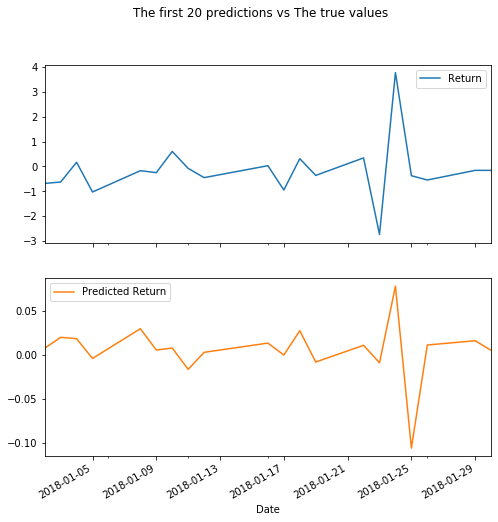

In [12]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(title='The first 20 predictions vs The true values', figsize=(12, 8))
Results[:20].plot(subplots=True, figsize=(8, 8), title='The first 20 predictions vs The true values')

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [13]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 1.1793759228548697


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [14]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 1.3077950542478285


# Conclusions

YOUR CONCLUSIONS HERE!

### lower RMSE is the the sign of fitness of our model, that is why this model perform better with in-Sample data utilization! 